Combine the ACF comparison and Bar Chart figures into one.

Drawing from the following notebooks:

- `p2021-0112a_ACF_comparison_BarChart.ipynb` (which does not actually have a bar chart, despite the name)
- `p2021-0421b_ACF_comparison.ipynb`
- `p2021-0528a_BarChart.ipynb` (which does actually have the bar chart)


## Setup

In [1]:
import os
import os.path as osp

In [2]:
import sys

In [3]:
sys.path.append('../modules')

In [4]:
import xvg_conversion as xvg

In [5]:
import numpy as np

In [6]:
import pandas as pd

In [7]:
from datetime import datetime

In [8]:
import matplotlib.pyplot as plt

In [9]:
%matplotlib inline

In [10]:
from ruamel.yaml import YAML

In [11]:
yaml=YAML(typ="safe",pure=True)

In [12]:
def readfile(fpath,multidoc=False):
  with open(fpath,"r") as fp:
    dat=fp.read()
  if multidoc:
    allobj=yaml.load_all(dat)
  else:
    allobj=yaml.load(dat)
  return allobj

## Output plot paths

In [13]:
outdir_top="../postproc/from_notebooks"
assert osp.isdir(outdir_top)

In [14]:
datestr=datetime.now().strftime("%Y_%m_%d")
datestr

'2021_06_09'

In [15]:
outdir=osp.join(outdir_top,datestr)

In [16]:
if not osp.isdir(outdir):
  os.makedirs(outdir)

In [17]:
assert osp.isdir(outdir)

## Constants

In [18]:
forcefield_names=["Jorgensen/SPC","GROMOS 53A6"]

In [19]:
acf_subdirs=['oldff-long','test05']

In [20]:
acf_fname="720_acf.xvg"

In [21]:
exp_std=0.01 #From Witherspoon and Saraf, 1965

In [22]:
plot_fname="ACF_Comparison_BarChart.png"

## Data paths

In [23]:
indir_msd=osp.join(outdir_top,"2020_12_04")
indir_acf=osp.join(outdir_top,"2021_01_12")

In [24]:
msd_res_infile=osp.join(indir_msd,"D_from_msd.yaml")
assert osp.isfile(msd_res_infile)

In [25]:
ff_comp_infile=osp.join(indir_acf,"FF_comparison_Dvalues.csv")
assert osp.isfile(ff_comp_infile)

In [26]:
acf_topdir="../jobs/run/bulk02"
assert osp.isdir(acf_topdir)

In [27]:
acf_data_folders=[osp.join(acf_topdir,sd) for sd in acf_subdirs]
assert all([osp.isdir(df) for df in acf_data_folders])

## Load data

PACF data

In [28]:
acf_data=[]
for idx,subdir in enumerate(acf_data_folders):
  acfpath=osp.join(subdir,acf_fname)
  assert osp.isfile(acfpath)
  corrdf=xvg.load_acf_xvg(acfpath)
  acf_data.append(corrdf)

D values (units of nm^2/nsec are expected)

In [29]:
msd_res=readfile(msd_res_infile)
msd_res

{'A': 2.391418647357853, 'B': 1.2102516482356547, 'C': 4.5069896623974115}

In [30]:
ff_comp_df=pd.read_csv(ff_comp_infile,index_col=0)
ff_comp_df

,Experimental,Selected Force Field,GROMOS 53A6
Direction,,,
x,1.88,3.134754,1.910608
y,1.88,2.958903,1.727854
z,1.88,3.061781,1.852438


## Processing

In [31]:
msd_arr=np.array([v for v in msd_res.values()])

In [32]:
# msd_avg=np.mean(msd_arr)
msd_avg=msd_arr.mean()
msd_avg

2.70288665266364

In [33]:
msd_std=msd_arr.std(ddof=1)
msd_std

1.670293274323906

In [34]:
msd_sem=msd_std/np.sqrt(msd_arr.shape[0])
msd_sem

0.9643442715565287

In [35]:
num_dirs=len(ff_comp_df)
assert num_dirs == 3

In [36]:
experimental=ff_comp_df["Experimental"].mean()
experimental

1.88

In [37]:
acf=ff_comp_df["Selected Force Field"].mean()
acf

3.05181238631671

In [38]:
acf_sem=ff_comp_df["Selected Force Field"].std(ddof=1)/np.sqrt(num_dirs)
acf_sem

0.05100785590367097

In [39]:
gromos=ff_comp_df["GROMOS 53A6"].mean()
gromos

1.8302999013115977

In [40]:
gromos_sem=ff_comp_df["GROMOS 53A6"].std(ddof=1)/np.sqrt(num_dirs)
gromos_sem

0.053905109765211706

## Plots

In [41]:
plot_fpath=osp.join(outdir,plot_fname)

In [42]:
coord="z"
tmax=25.0
#tmax=50.0

In [43]:
formats=['r-','k--']

In [44]:
heights=[experimental,gromos,acf,msd_avg]
errors=[exp_std,gromos_sem,acf_sem,msd_sem]
categories_short=["Experiment","PACF\nGROMOS","ACF\nSilicate","MSD"]
categories_full=["Experiment","PACF:\nGROMOS 53A6\nForce Field","PACF:\nJorgensen/SPC\nForce Field",
                 "Mean\nfrom MSD\nTrials"]

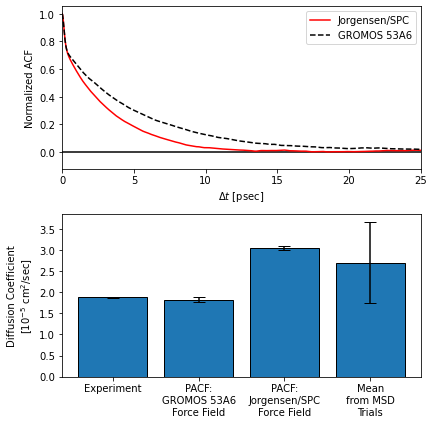

In [45]:
fig,axlist=plt.subplots(2,1,figsize=(6,6))

#PACF curves
ax=axlist[0]
for idx,tag in enumerate(forcefield_names):
  acf_df=acf_data[idx]
  o=ax.plot(acf_df['t'],acf_df[coord],formats[idx],label=tag)
o=ax.set_xlim(0,tmax)
o=ax.hlines(0,0,tmax,'k')
o=ax.legend(loc="upper right")
#o=ax.set_title("")
o=ax.set_ylabel("Normalized ACF")
o=ax.set_xlabel("$\Delta t$ [psec]")

#D bar chart
ax=axlist[1]
o=ax.bar(categories_full,heights,yerr=errors,edgecolor="k",capsize=6)
o=ax.set_ylabel("Diffusion Coefficient\n[$10^{-5}$ cm$^2$/sec]") #,fontsize=20)

#Done
fig.tight_layout()
fig.savefig(plot_fpath,dpi=300)